# Correlated Truncation Errors in Effective Field Theory: The code behind the manuscript

This notebook provides the code to reproduce all of the plots from Melendez et al. (2019).

In [1]:
%load_ext autoreload
%autoreload 2

import gsum as gm
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import os
import h5py
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

%matplotlib inline

In [2]:
cmaps = [plt.get_cmap(name) for name in ['Oranges', 'Greens', 'Blues', 'Reds']]
# markers = ['o', '^', 'v', 's']
markers = None
# line_col = 0.55
# band_col = 0.3
dark_col = 0.8
medium_dark_col = 0.6
medium_col = 0.5
medium_light_col = 0.33
light_col = 0.25
dark_colors = [cmap(dark_col) for cmap in cmaps]
medium_colors = [cmap(medium_col) for cmap in cmaps]
light_colors = [cmap(light_col) for cmap in cmaps]
medium_dark_colors = [cmap(medium_dark_col) for cmap in cmaps]
medium_light_colors = [cmap(medium_light_col) for cmap in cmaps]

## Figure 1: Predictions to Coefficients

In [3]:
x = np.linspace(0, 1, 100)
X = x[:, None]
n_orders = 4
orders = np.arange(0, n_orders)

# The true values of the hyperparameters for generating data
ls = 0.2
sd = 1
center = 0
ref = 10
ratio = 0.5
nugget = 1e-10
seed = 3


# X_mask = np.array([i % 5 == 0 for i in range(len(X_all))])[:, None]

kernel = RBF(length_scale=ls, length_scale_bounds='fixed') + \
    WhiteKernel(noise_level=nugget, noise_level_bounds='fixed')
gp = gm.ConjugateGaussianProcess(kernel=kernel, center=center, df=np.inf, scale=sd, nugget=0)

# Draw coefficients and then use `partials` to create the toy order-by-order EFT predictions
coeffs = gp.sample_y(X, n_samples=n_orders, random_state=seed)
data = -gm.partials(coeffs, ratio, ref=ref, orders=orders)  # Negative sign to make them positive
diffs = np.array([data[:, 0], *np.diff(data, axis=1).T]).T

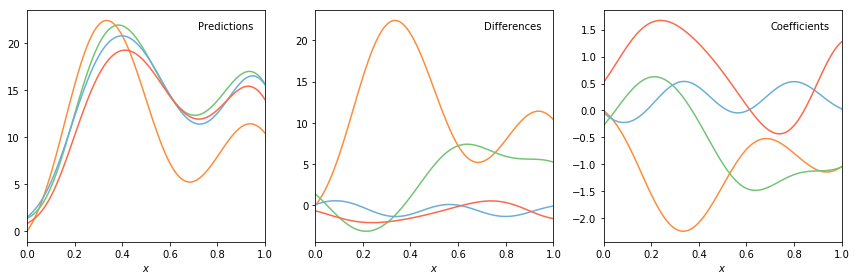

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i in range(n_orders):
    axes[0].plot(x, data[:, i], c=medium_colors[i])
    axes[1].plot(x, diffs[:, i], c=medium_colors[i])
    axes[2].plot(x, coeffs[:, i], c=medium_colors[i])
    
for ax, label in zip(axes, ['Predictions', 'Differences', 'Coefficients']):
    ax.set_xlabel(r'$x$')
    ax.set_xlim(0, 1)
    ax.text(0.95, 0.95, label, ha='right', va='top', transform=ax.transAxes)
fig.tight_layout();

## Figure 3: Curvewise vs Pointwise Analysis

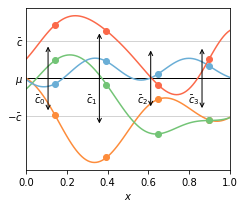

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))

# Draw curves and points
mask = np.array([(i-14) % 25 == 0 for i in range(len(x))])
for i, c in enumerate(coeffs.T):
    ax.plot(x, c, color=medium_colors[i], zorder=0)
    ax.plot(x[mask], c[mask], ls='', marker='o', color=medium_colors[i])

for i, xi in enumerate(x[mask]):
    # Fit a Gaussian to the orders at this x_i
    sd_fit = stats.norm.fit(coeffs[mask][i], floc=0, shape=len(coeffs[mask]))[1]
    # Draw a vertical arrow showing mean +/- sd
    ax.annotate("", xy=(xi-0.035, sd_fit), xytext=(xi-0.035, -sd_fit),
                arrowprops=dict(arrowstyle="<->", capstyle='projecting', lw=1), zorder=1)
    ax.text(xi-0.075, -0.55, r'$\bar c_{}$'.format(i), horizontalalignment='center',
            verticalalignment='center', zorder=1)    

# Format plot
ax.axhline(0, 0, 1, c='k', lw=1, zorder=-1)
ax.axhline(1, 0, 1, c='lightgrey', lw=1, zorder=-1)
ax.axhline(-1, 0, 1, c='lightgrey', lw=1, zorder=-1)
ax.set_yticks([-1, 0, 1])
ax.set_yticklabels([r'$-\bar c$', r'$\mu$', r'$\bar c$'])
ax.tick_params(length=0, axis='y')
ax.set_xlabel(r'$x$')
ax.set_xlim([0, 1])

fig.tight_layout();

## Figure 4: Interpolation and Regression with Gaussian Processes

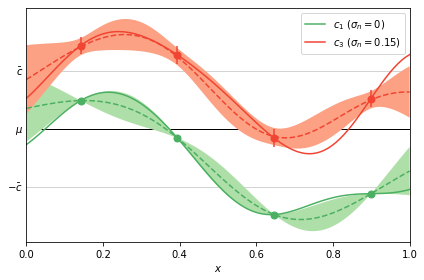

In [6]:
regres_sd = 0.15

# Set up gp objects with fixed mean and standard deviation
gp_interp = gm.ConjugateGaussianProcess(
    kernel=kernel, center=center, disp=0, df=np.inf, scale=sd, nugget=0)
gp_regres = gm.ConjugateGaussianProcess(
    kernel=kernel, center=center, disp=0, df=np.inf,
    scale=sd, nugget=regres_sd**2)

# Condition on data and make predictions
interp_idx = 1
gp_interp.fit(X[mask], coeffs[mask, [interp_idx]])
pred_interp, std_interp = gp_interp.predict(X, return_std=True)

regres_idx = 3
gp_regres.fit(X[mask], coeffs[mask, [regres_idx]])
pred_regres, std_regres = gp_regres.predict(X, return_std=True)


fig, ax = plt.subplots()

# Interpolating curve
ax.plot(x, coeffs[:, [interp_idx]], c=medium_dark_colors[interp_idx],
        label=r'$c_{}$ ($\sigma_n = 0$)'.format(interp_idx))
ax.plot(x, pred_interp, c=medium_dark_colors[interp_idx], ls='--')
ax.plot(x[mask], coeffs[mask, interp_idx], ls='', marker='o', c=medium_dark_colors[interp_idx], markersize=7)
ax.fill_between(x, pred_interp-std_interp, pred_interp+std_interp, facecolor=medium_light_colors[interp_idx])

# With noise
ax.plot(x, coeffs[:, [regres_idx]], c=medium_dark_colors[regres_idx],
        label=r'$c_{}$ ($\sigma_n = 0.15$)'.format(regres_idx))
ax.plot(x, pred_regres, c=medium_dark_colors[regres_idx], ls='--')
ax.errorbar(x[mask], coeffs[mask, regres_idx], regres_sd, c=medium_dark_colors[regres_idx],
            ls='', marker='o', markersize=7)
ax.fill_between(x, pred_regres-std_regres, pred_regres+std_regres, facecolor=medium_light_colors[regres_idx])

# Format plot
ax.axhline(0, 0, 1, c='k', lw=1, zorder=-1)
ax.axhline(1, 0, 1, c='lightgrey', lw=1, zorder=-1)
ax.axhline(-1, 0, 1, c='lightgrey', lw=1, zorder=-1)
ax.set_yticks([-1, 0, 1])
ax.set_yticklabels([r'$-\bar c$', r'$\mu$', r'$\bar c$'])
ax.tick_params(length=0, axis='y')
ax.set_xlim(0, 1)
ax.set_xlabel(r'$x$')
ax.legend()

fig.tight_layout();

## Figure 5: GP Priors



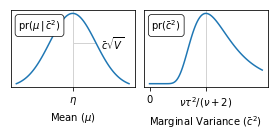

In [7]:
mean = 0
disp = 1
df = 15
tau2 = (df + 2) / df
gaussian_sd = np.sqrt(tau2*disp)

# Convert to inverse gamma
a = df / 2.
b = df * tau2 / 2.

gaus = stats.norm(mean, gaussian_sd)
igam = stats.invgamma(a, scale=b)
mu_vals = np.linspace(-2.6, 2.6, 100)
cbar_vals = np.linspace(0, 2, 100)

fig, ax = plt.subplots(1, 2, figsize=(4, 2))

# Plot curves
ax[0].plot(mu_vals, gaus.pdf(mu_vals))
ax[1].plot(cbar_vals, igam.pdf(cbar_vals))

# Add text boxes
ax[0].text(0.06, 0.9, r'pr($\mu \,|\, \bar c^2$)', ha='left', va='top',
           transform=ax[0].transAxes,
           bbox=dict(boxstyle='round', fc="w", ec="k", lw=0.7))
ax[1].text(0.06, 0.9, r'pr($\bar c^2$)', ha='left', va='top',
           transform=ax[1].transAxes,
           bbox=dict(boxstyle='round', fc="w", ec="k", lw=0.7))

# Format plots
line_color = 'lightgrey'
ax[0].set_xlabel(r'Mean ($\mu$)')
ax[1].set_xlabel(r'Marginal Variance ($\bar c^2$)')
ax[0].set_yticks([])
ax[1].set_yticks([])

ax[0].axvline([mean], 0, 1, c=line_color, zorder=0, lw=1)
ax[0].set_xticks([mean])
ax[0].set_xticklabels([r'$\eta$'])
ax[0].arrow(0, gaus.pdf(gaussian_sd), gaussian_sd, 0, color=line_color, head_width=0., width=0.0001)
ax[0].text(gaussian_sd+0.25, gaus.pdf(gaussian_sd), r'$\bar c\sqrt{V}$',
           verticalalignment='center', horizontalalignment='left')

ax[1].axvline([df * tau2 / (df+2)], 0, 1, c=line_color, zorder=0, lw=1)
ax[1].set_xticks([0, df * tau2 / (df+2)])
ax[1].set_xticklabels([0, r'$\nu\tau^2/(\nu+2)$'])

fig.tight_layout(w_pad=0);

## Figure 6: Applications

### Inexpensive Systems

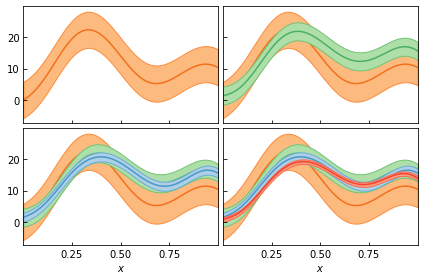

In [8]:
trunc_gp = gm.TruncationGP(kernel=kernel, ref=ref, ratio=ratio, disp=0, df=np.inf, optimizer=None)
trunc_gp.fit(X[mask], data[mask], orders=orders)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
for i, n in enumerate(orders):
    _, std_trunc = trunc_gp.predict(X, order=n, return_std=True, kind='trunc')
    
    for j in range(i, 4):
        ax = axes.ravel()[j]
        ax.plot(x, data[:, i], zorder=i-5, c=medium_dark_colors[i])
        ax.fill_between(x, data[:, i]+std_trunc, data[:, i]-std_trunc,
                        zorder=i-5, facecolor=medium_light_colors[i], edgecolor=medium_colors[i])
    ax = axes.ravel()[i]
    ax.tick_params(which='both', direction='in')
    ax.set_xlim(0, 1)
    ax.set_xticks([0.25, 0.5, 0.75])
    ax.set_yticks([0, 10, 20])
# Format
axes[1, 0].set_xlabel(r'$x$')
axes[1, 1].set_xlabel(r'$x$')
fig.tight_layout(h_pad=0.5, w_pad=0.5);

### Expensive Systems

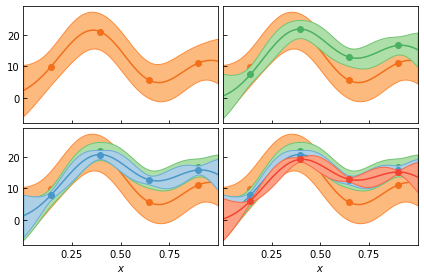

In [9]:
trunc_gp_exp = gm.TruncationGP(kernel=kernel, ref=ref, ratio=ratio, disp=0, df=np.inf, optimizer=None)
trunc_gp_exp.fit(X[mask], data[mask], orders=orders)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
for i, n in enumerate(orders):
    pred_exp, std_trunc_exp = trunc_gp_exp.predict(X, order=n, return_std=True)
    
    for j in range(i, 4):
        ax = axes.ravel()[j]
        ax.plot(x, pred_exp, zorder=i-5, c=medium_dark_colors[i])
        ax.plot(x[mask], data[mask, i], ls='', c=medium_dark_colors[i], marker='o', zorder=i-5)
        ax.fill_between(x, pred_exp+std_trunc_exp, pred_exp-std_trunc_exp,
                        zorder=i-5, facecolor=medium_light_colors[i], edgecolor=medium_colors[i])
    ax = axes.ravel()[i]
    ax.tick_params(which='both', direction='in')
    ax.set_xlim(0, 1)
    ax.set_xticks([0.25, 0.5, 0.75])
    ax.set_yticks([0, 10, 20])
# Format
axes[1, 0].set_xlabel(r'$x$')
axes[1, 1].set_xlabel(r'$x$')
fig.tight_layout(h_pad=0.5, w_pad=0.5);

### Constraints

In [10]:
x2 = np.linspace(0, 1, 50)
X2 = x2[:, None]
kernel2 = RBF(length_scale=0.25) + WhiteKernel(noise_level=1e-7)

gp_constrained = gm.ConjugateGaussianProcess(kernel=kernel2, optimizer=None).fit([[0], [1]], [0, 0])
cn_constrained = gp_constrained.sample_y(X2, n_samples=n_orders, random_state=5)
yn_constrained = gm.partials(cn_constrained, ratio=ratio)

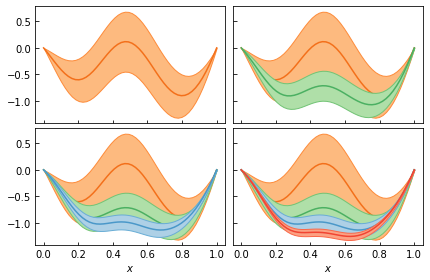

In [11]:
trunc_gp_sym = gm.TruncationGP(kernel=kernel2, ref=1, ratio=ratio, disp=0, df=np.inf, optimizer=None)
trunc_gp_sym.fit(X2[::10], yn_constrained[::10], orders=orders, dX=np.array([[0], [1]]), dy=np.array([0, 0]))

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
for i, n in enumerate(orders):
    _, std_sym = trunc_gp_sym.predict(X2, order=n, return_std=True, kind='trunc')
    
    for j in range(i, 4):
        ax = axes.ravel()[j]
        ax.plot(x2, yn_constrained[:, i], zorder=i, c=medium_dark_colors[i])
        ax.fill_between(x2, yn_constrained[:, i]+std_sym, yn_constrained[:, i]-std_sym,
                        zorder=i, facecolor=medium_light_colors[i], edgecolor=medium_colors[i])
    ax = axes.ravel()[i]
    ax.tick_params(which='both', direction='in')
# Format
axes[1, 0].set_xlabel(r'$x$')
axes[1, 1].set_xlabel(r'$x$')
fig.tight_layout(h_pad=0.5, w_pad=-0.1);

## Diagnostics



In [12]:
def regular_train_test_split(x, dx_train, dx_test, offset_train=0, offset_test=0, xmin=None, xmax=None):
    train_mask = np.array([(i - offset_train) % dx_train == 0 for i in range(len(x))])
    test_mask = np.array([(i - offset_test) % dx_test == 0 for i in range(len(x))])
    if xmin is None:
        xmin = np.min(x)
    if xmax is None:
        xmax = np.max(x)
    train_mask = train_mask & (x >= xmin) & (x <= xmax)
    test_mask = test_mask  & (x >= xmin) & (x <= xmax) & (~ train_mask)
    return train_mask, test_mask

In [13]:
x_train_mask, x_valid_mask = regular_train_test_split(
    x, dx_train=24, dx_test=6, offset_train=1, offset_test=1)

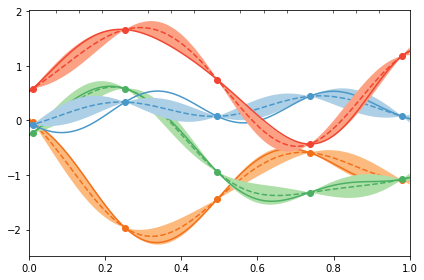

In [14]:
gp_diagnostic = gm.ConjugateGaussianProcess(kernel=kernel, disp=0)
gp_diagnostic.fit(X[x_train_mask], coeffs[x_train_mask])
pred, std = gp_diagnostic.predict(X, return_std=True)

fig, ax = plt.subplots()
for i in range(n_orders):
    ax.plot(x, pred[:, i], c=medium_dark_colors[i], zorder=i-5, ls='--')
    ax.plot(x, coeffs[:, i], c=medium_dark_colors[i], zorder=i-5)
    ax.plot(x[x_train_mask], coeffs[x_train_mask, i], c=medium_dark_colors[i], zorder=i-5, ls='', marker='o')
    ax.fill_between(x, pred[:, i]+std, pred[:, i]-std, zorder=i-5,
                     facecolor=medium_light_colors[i], alpha=1)
ax.set_xlim(0, 1)
ax.set_xticks(x[x_valid_mask], minor=True)
ax.tick_params(which='minor', bottom=False, top=True, direction='in', length=3)
fig.tight_layout();